In [1]:
import hydra
import torch
from hydra import compose, initialize
from models import evaluate
from core.custom_dataset import CustomDataset
from torch_dreams.auto_image_param import AutoImageParam
import torchvision

Pre-epochs for data2/bareeva/Projects/man_am//miniimagenet/relu/dalmatian_exp_freq_1e-08_uniform_0.1_0.1_200.0_1e-06_uniform_32_32_model.pth: 

39

In [2]:
def feature_visualisation(
    net,
    noise_dataset,
    man_index,
    lr,
    n_steps,
    save_list=[],
    init_mean=torch.tensor([]),
    D=None,
    probs=False,
    grad_clip=None,
    show=True,
    tf=torchvision.transforms.Compose([]),
    adam=False,
    device="cuda:1",
):
    net.eval()
    f = noise_dataset.forward

    tstart = noise_dataset.get_init_value()
    if len(init_mean) > 0:
        tstart += init_mean
    tstart = tstart.to(device).requires_grad_()

    optimizer_fv = torch.optim.SGD([tstart], lr=lr)
    if adam:
        optimizer_fv = torch.optim.Adam([tstart], lr=lr)
    torch.set_printoptions(precision=8)

    for n in range(n_steps):
        optimizer_fv.zero_grad()

        y_t = net.__call__(tf(f(tstart)))[0]
        loss = -y_t[man_index].mean()

        if D is not None:
            loss -= D(f(tstart).reshape(1, -1)).item()
        # print(loss)
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_([tstart], grad_clip)
        optimizer_fv.step()

        if n + 1 in save_list:
            print(n)
            fwrd = noise_dataset.to_image(tstart)
            torchvision.utils.save_image(fwrd[0], f"../out/{n}_dalm.jpg")

    # tstart = tstart.detach()
    fwrd = noise_dataset.to_image(tstart)
    target = noise_dataset.target
    return fwrd, target, tstart

In [3]:
data = "miniimagenet"
model = "rs50"
img_str = "dalmatian_og"
# alpha = 0.0
# lr = 1e-06
target_img_path = "./assets/adv_train/dalmatian.jpg"
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config",
        overrides=[
            f"data={data}",
            f"model={model}",
            f"target_img_path={target_img_path}",
            # f"alpha={alpha}", f"lr={lr}",
            f"img_str={img_str}",  # f"lr={lr}"
        ],
    )

In [4]:
device = "cuda:1"
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
input_layer_str = cfg.model.get("input_layer", None)
layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = "." + cfg.data.get("class_dict_file", None)

fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size

In [5]:
transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

In [6]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet

noise_dataset = (
    FrequencyManipulationSet(
        image_dims,
        "." + target_img_path,
        normalize,
        denormalize,
        transforms,
        resize_transforms,
        n_channels,
        1e-9,
        "normal",
        device,
    )
    if fv_domain == "freq"
    else RGBManipulationSet(
        image_dims,
        "." + target_img_path,
        normalize,
        denormalize,
        transforms,
        resize_transforms,
        n_channels,
        1e-9,
        "normal",
        device,
    )
)

In [7]:
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=data_dir + cfg.data.data_path
)

train_loader = torch.utils.data.DataLoader(
    CustomDataset(train_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

In [8]:
import torchvision.transforms as transforms

image_transforms = transforms.Compose(
    [
        transforms.Pad(2, fill=0.5, padding_mode="constant"),
        transforms.RandomAffine((-20, 20), scale=(0.75, 1.025), fill=0.5),
        transforms.RandomRotation((-20, 21)),
        transforms.RandomCrop(
            (224, 224),
            padding=None,
            pad_if_needed=True,
            fill=0,
            padding_mode="constant",
        ),
    ]
)

In [9]:
import matplotlib.pyplot as plt
from torch_dreams import Dreamer

target_neuron = int(cfg.model.target_neuron)


def make_custom_func(layer_number=0, channel_number=0):
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][0][channel_number].mean()
        return -loss

    return custom_func


my_custom_func = make_custom_func(layer_number=0, channel_number=target_neuron)

image_parameter = AutoImageParam(
    height=image_dims, width=image_dims, device=device, standard_deviation=1e-8
)
# image_parameter.param = torch.zeros((1, 3, image_dims, image_dims)).float().to(device)
# image_parameter.optimizer = torch.optim.SGD([image_parameter.param], lr=0.03)

In [10]:
model = hydra.utils.instantiate(cfg.model.model)
model.to(device)
model.eval()
dreamer = Dreamer(model, device=device)
null_transforms = transforms.Compose([])
# dreamer.set_custom_transforms(null_transforms)


evaluate(model, test_loader, device)

100%|██████████| 1/1 [00:00<00:00, 61.80it/s]


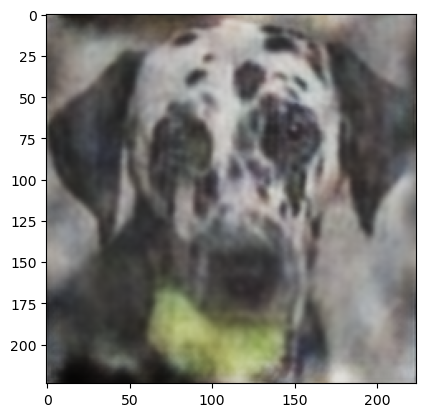

In [20]:
image_param = dreamer.render(
    layers=[model.__getattr__(layer_str)],
    custom_func=my_custom_func,
    width=image_dims,
    height=image_dims,
    iters=1,
    image_parameter=image_parameter,
    lr=0.005,
)

plt.imshow(image_param)
plt.show()

In [ ]:
path = "{}/{}/{}/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_model.pth".format(
    output_dir,
    dataset.dataset_name,
    "softplus" if replace_relu else "relu",
    img_str,
    fv_domain,
    str(fv_sd),
    fv_dist,
    str(alpha),
    str(w),
    gamma,
    lr,
    fv_dist,
    batch_size,
    man_batch_size,
)

image_parameter = AutoImageParam(
    height=image_dims, width=image_dims, device=device, standard_deviation=1e-9
)
# image_parameter.param = torch.zeros((1, 3, image_dims, image_dims)).float().to(device)
image_parameter.optimizer = torch.optim.SGD([image_parameter.param], lr=5.0)

model_dict = torch.load(path, map_location=torch.device(device))
model.load_state_dict(model_dict["model"])
model.eval()
dreamer = Dreamer(model, device=device)
null_transforms = transforms.Compose([])
dreamer.set_custom_transforms(image_transforms)
dreamer.set_custom_transforms(null_transforms)
image_param = dreamer.render(
    layers=[model.__getattr__(layer_str)],
    custom_func=my_custom_func,
    image_parameter=image_parameter,
    width=image_dims,
    height=image_dims,
    iters=1,
    lr=0.05,
)

plt.imshow(image_param)
plt.show()

In [13]:
path

'/data2/bareeva/Projects/man_am//miniimagenet/relu/dalmatian_og_freq_1e-08_uniform_0.1_0.1_200.0_1e-06_uniform_32_32_model.pth'

0
4
9
19
49
99
1999


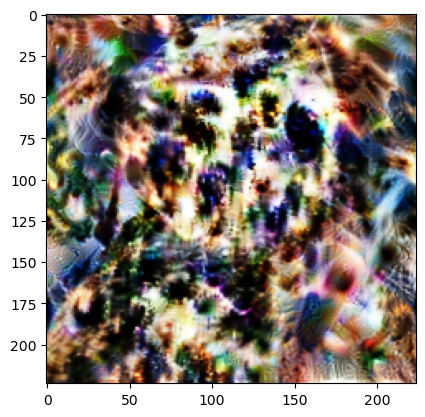

In [14]:
i = 2000
img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.005,
    n_steps=i,
    init_mean=torch.tensor([]),
    save_list=[1, 5, 10, 20, 50, 100, 2000],
    # tf = image_transforms,
    # grad_clip=True,
    # adam=True,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

torchvision.utils.save_image(img[0], f"../out/{i}_dalm.jpg")

In [15]:
evaluate(model, test_loader, device)

Accuracy of the network on test images: 81.8583 %


81.8583

In [21]:
f = noise_dataset.forward
param = noise_dataset.parametrize(img)
y_t = model.forward(f(param))[0]
print(
    torch.autograd.grad(y_t[target_neuron], param, create_graph=True)[0]
    .abs()
    .pow(2)
    .mean()
)

tensor(6.38179159, device='cuda:1', grad_fn=<MeanBackward0>)


In [22]:
(param - noise_dataset.param).std()

tensor(0.03635621, device='cuda:1', grad_fn=<StdBackward0>)

In [23]:
(param - noise_dataset.param).abs().mean()

tensor(0.02553193, device='cuda:1', grad_fn=<MeanBackward0>)